<a href="https://colab.research.google.com/github/pullz6/ADS1-Visualisation/blob/main/Aircraft_Turbo_Defect_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install img2vec_pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import pandas as pd
from img2vec_pytorch import Img2Vec
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Adding the images in.

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train',labels=None,image_size=(64,64),batch_size=32,color_mode='grayscale')
test_data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/val',labels=None,image_size=(64,64), batch_size=32,color_mode='grayscale')

Found 257 files belonging to 1 classes.
Found 73 files belonging to 1 classes.


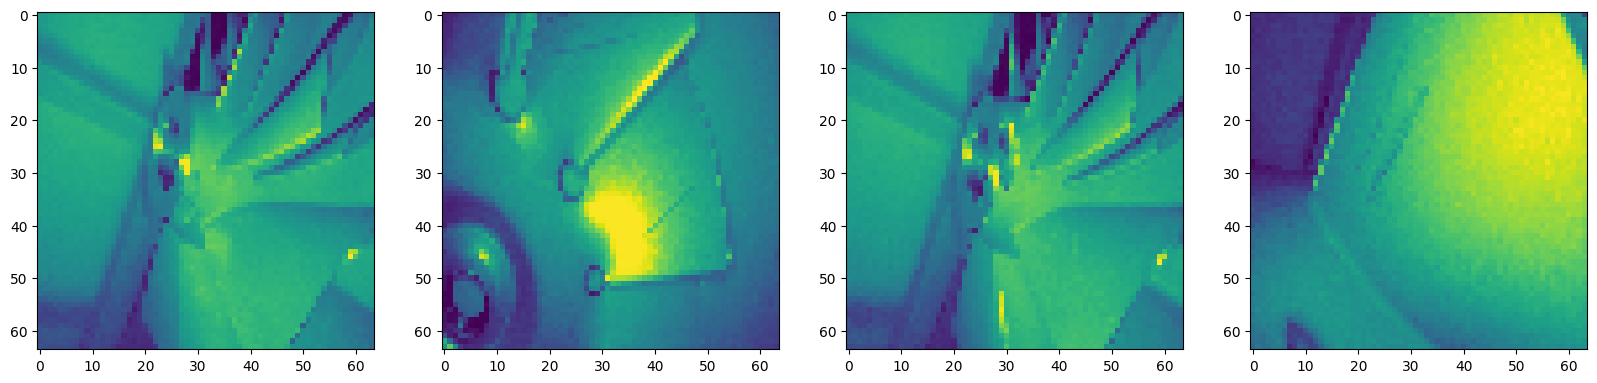

In [ ]:
train_data_iterator = train_data.as_numpy_iterator()
batch = train_data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[:4]):
    ax[idx].imshow(img.astype(int))

In [ ]:
name_train = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train')
name_val = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/val')

print("Names of the train images:", name_train)
print("Names of the validation images:", name_val)

Names of the train images: ['12.jpg', '12_rot1.jpg', '10_rot1.jpg', '10_flip1.jpg', '1.jpg', '12_3.jpg', '10_1.jpg', '10_rot2.jpg', '13_flip1.jpg', '11_2.jpg', '13_3.jpg', '11_flip1.jpg', '13.jpg', '12_flip1.jpg', '12_flip.jpg', '10.jpg', '13_rot1.jpg', '11_flip0.jpg', '11.jpg', '13_flip.jpg', '12_rot2.jpg', '11_rot1.jpg', '12_flip0.jpg', '12_2.jpg', '10_flip.jpg', '10_flip0.jpg', '13_rot3.jpg', '15_rot1.jpg', '18_1.jpg', '15_2.jpg', '16_flip.jpg', '14_3.jpg', '14_rot1.jpg', '17_flip0.jpg', '15_flip1.jpg', '14_2.jpg', '17.jpg', '18_3.jpg', '17_2.jpg', '17_3.jpg', '18_2.jpg', '18_rot2.jpg', '17_flip1.jpg', '15_3.jpg', '14.jpg', '14_flip.jpg', '17_rot2.jpg', '17_1.jpg', '15_rot3.jpg', '16_rot3.jpg', '15_flip.jpg', '14_rot2.jpg', '17_rot3.jpg', '14_1.jpg', '15_rot2.jpg', '16_flip1.jpg', '16_rot1.jpg', '14_flip1.jpg', '17_rot1.jpg', '17_4.jpg', '15_1.jpg', '15.jpg', '18_rot1.jpg', '1_flip.jpg', '2023-04-06 19-34-32-225.jpg', '21_rot3.jpg', '2023-04-06 19-30-40-910.jpg', '2023-04-06 19-34-3

Reading the category and the location of the data in the labels file

In [ ]:
# Folder Path
path_train = "/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/train"
label_train = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/train')
label_val = os.listdir('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/val')

def return_dfs(path, os_path ,df):
  images = []
  defect_type = []
  x1 = []
  y1 = []
  x2 = []
  y2 = []
  for name in os_path:
    images.append(name)
    text_file = open(path+name,'r')
    line_list = text_file.readlines();
    #for each line from the list, print the line
    t = 0
    for line in line_list:
      #Read the values, which comes as a string, segregate it by the space and create a list

      #In case there are two lines, we need to include the name twice in the opposing list, if not the lists lengths will be unequal.
      if t!=0:
        images.append(name)

      #Divide the strings by the space
      values = line.split(" ")

      #Add the values into lists
      defect_type.append(values[0])
      x1.append(values[1])
      y1.append(values[2])
      x2.append(values[3])
      y2.append(values[4])

      t = t+1

  #don't forget to close the file
    text_file.close()

  df = pd.DataFrame(columns = ['Image','Defect_Type','x1','y1','x2','y2'])
  df.Image = images
  df.Defect_Type = defect_type
  df.x1 = x1
  df.x2 = x2
  df.y1 = y1
  df.y2 = y2
  df.y2 = df["y2"].str.replace('\n','')
  return df

train_df = pd.DataFrame()
train_df = return_dfs('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/train/',label_train,train_df)
val_df = pd.DataFrame()
val_df = return_dfs('/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/labels/val/',label_val,val_df)

In [ ]:
val_df

,Image,Defect_Type,x1,y1,x2,y2
0,22_2.txt,0,0.693856,0.172222,0.042373,0.077778
1,11_1.txt,3,0.110699,0.937500,0.113347,0.113889
2,4.txt,0,0.560662,0.336214,0.197304,0.465836
3,4.txt,0,0.747243,0.336214,0.138480,0.392685
4,26.txt,0,0.337010,0.395900,0.158701,0.163183
...,...,...,...,...,...,...
72,23_1.txt,0,0.683792,0.187500,0.083686,0.258333
73,14_3.txt,0,0.500530,0.772222,0.028602,0.058333
74,14_3.txt,0,0.712394,0.581250,0.176907,0.076389
75,14_3.txt,0,0.814619,0.668056,0.074153,0.077778


In [ ]:
image_train = (train_df['Image'].str.replace('.txt','')).to_list()
image_val = (val_df['Image'].str.replace('.txt','')).to_list()

def checker(train_value, val_value):
  """This function checks the train value and validation value passed through are equal"""
  if str(train_value)==str(val_value):
    return True
  else:
    return False

checker_res = []

print(len(image_val))

for x in image_train:
  t = 0

  for y in image_val:

    if t<=len(image_val):
      temp = checker(x,y)
      if temp == True:
        checker_res.append(temp)
        break
      else:
        continue
    else:
      checker_res.append(False)

    t = t+1


print(len(checker_res))

77
67


Data Cleaning and Preparation

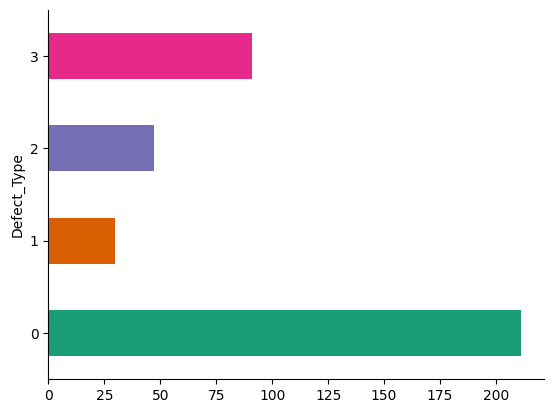

In [ ]:
#Checking to see which defects are common
from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('Defect_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

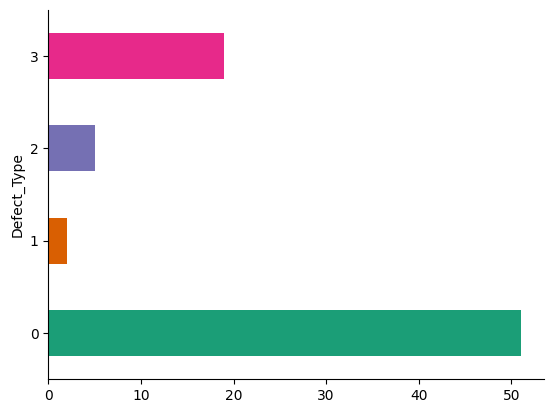

In [ ]:
#Checking to see which defects are common
from matplotlib import pyplot as plt
import seaborn as sns
val_df.groupby('Defect_Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def return_sorted_defects (x,df):
  """This function takes the numerical value of a defect and returns a list of images that has that defect"""
  df_filtered = df[df['Defect_Type']==str(x)]
  image_files = df_filtered['Image'].str.replace('.txt','.jpg')
  image_files = list(dict.fromkeys(image_files))
  return image_files

#Having seperate lists per defect
images_0 = return_sorted_defects(0, train_df)
images_1 = return_sorted_defects(1, train_df)
images_2 = return_sorted_defects(2, train_df)
images_3 = return_sorted_defects(3, train_df)

The below creates a seperate file organisation for each of the defects, this is only to run once.

In [ ]:
from functools import partial

root_directory = '/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train'

list = ('Scratch', 'Dot', 'Crease','Damage')

concat_root_path = partial(os.path.join, root_directory)
make_directory = partial(os.makedirs, exist_ok=True)

for path_items in map(concat_root_path, list):
    make_directory(path_items)

Re-organising and shifting images into the respective defect folder that was created above.

In [ ]:
import shutil
not_in = []
def move_items(list_items, defect):
    """Move the images back into the new location"""
    try:
      for file in list_items:
        src_path = "/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train/"+file
        new_path = "/content/drive/My Drive/sample_data/Projects/Aircraft_Turbo_Defects/images/train/"+defect+"/"+file
        shutil.move(src_path, new_path)
    except:
        print(file+ " No added")
        not_in.append(file)

move_items(images_0,"Scratch")
move_items(images_1,"Dot")
move_items(images_2,"Crease")
move_items(images_3,"Damage")

3.jpg No added
2023-04-06 19-30-33-675.jpg No added
7_rot2.jpg No added
14_rot3.jpg No added


Running the above for the validation dataset

In [ ]:
#Having seperate lists per defect
images_0 = return_sorted_defects(0, val_df)
images_1 = return_sorted_defects(1, val_df)
images_2 = return_sorted_defects(2, val_df)
images_3 = return_sorted_defects(3, val_df)

TypeError: 'tuple' object is not callable

In [ ]:
print(not_in)